# Crop Yield Prediction - Deep Learning

Use NUTS3 input data to produce NUTS3 crop yield forecasts. Aggregate forecasts to NUTS2 level and train model using weak supervision from NUTS2 yield statistics.

In [ ]:
test_env = 'notebook'
if (test_env == 'notebook'):
  !pip install d2l==0.16.1 >/dev/null

  from d2l import torch as d2l
  import numpy as np
  import torch
  from torch import nn
  import pandas as pd
  import matplotlib.pyplot as plt
  %matplotlib inline
  plt.rcParams['figure.figsize'] = [30,25]
  plt.rcParams.update({'font.size': 12})

  !pip install pyspark > /dev/null
  !sudo apt update > /dev/null
  !apt-get install openjdk-8-jdk-headless -qq > /dev/null
  !pip install joblibspark > /dev/null

  import os
  os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
else:  
  import findspark
  findspark.init()

import pyspark
from pyspark.sql import functions as SparkF
from pyspark.sql import types as SparkT

from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

SparkContext.setSystemProperty('spark.executor.memory', '12g')
SparkContext.setSystemProperty('spark.driver.memory', '6g')
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

# crop name to id mapping
crop_id_dict = {
    'grain maize': 2,
    'sugar beet' : 6,
    'sugarbeet' : 6,
    'sugarbeets' : 6,
    'sugar beets' : 6,
    'total potatoes' : 7,
    'potatoes' : 7,
    'potato' : 7,
    'winter wheat' : 90,
    'soft wheat' : 90,
    'sunflower' : 93,
    'spring barley' : 95,
}

# crop id to name mapping
crop_name_dict = {
    2 : 'grain maize',
    6 : 'sugarbeet',
    7 : 'potatoes',
    90 : 'soft wheat',
    93 : 'sunflower',
    95 : 'spring barley',
}

## Utility Functions

In [ ]:
import sklearn
from sklearn.metrics import mean_squared_error

from pyspark.sql import Window

# crop name and id mappings
def cropNameToID(crop_id_dict, crop):
  """
  Return id of given crop. Relies on crop_id_dict.
  Return 0 if crop name is not in the dictionary.
  """
  crop_lcase = crop.lower()
  try:
    crop_id = crop_id_dict[crop_lcase]
  except KeyError as e:
    crop_id = 0

  return crop_id

def cropIDToName(crop_name_dict, crop_id):
  """
  Return crop name for given crop ID. Relies on crop_name_dict.
  Return 'NA' if crop id is not found in the dictionary.
  """
  try:
    crop_name = crop_name_dict[crop_id]
  except KeyError as e:
    crop_name = 'NA'

  return crop_name

def getYear(date_str):
  """Extract year from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.year(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.year(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getMonth(date_str):
  """Extract month from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.month(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.month(SparkF.to_date(date_str, 'dd/MM/yyyy')))

def getDay(date_str):
  """Extract day from date in yyyyMMdd or dd/MM/yyyy format."""
  return SparkF.when(SparkF.length(date_str) == 8,
                     SparkF.dayofmonth(SparkF.to_date(date_str, 'yyyyMMdd')))\
                     .otherwise(SparkF.dayofmonth(SparkF.to_date(date_str, 'dd/MM/yyyy')))

# 1-10: Dekad 1
# 11-20: Dekad 2
# > 20 : Dekad 3
def getDekad(date_str):
  """Extract dekad from date in YYYYMMDD format."""
  month = getMonth(date_str)
  day = getDay(date_str)
  return SparkF.when(day < 30, (month - 1)* 3 +
                     SparkF.ceil(day/10)).otherwise((month - 1) * 3 + 3)

def getFilename(crop, yield_trend, early_season_end,
                country=None, nuts_level=None):
  """Get filename based on input arguments"""
  suffix = crop.replace(' ', '_')

  if (country is not None):
    suffix += '_' + country

  if (nuts_level is not None):
    suffix += '_' + nuts_level

  if (yield_trend):
    suffix += '_trend'
  else:
    suffix += '_notrend'

  if (early_season_end < 0):
    suffix += '_early' + str(early_season_end)

  return suffix

def getLogFilename(crop, yield_trend, early_season_end,
                   country=None):
  """Get filename for experiment log"""
  log_file = getFilename(crop, yield_trend, early_season_end, country)
  return log_file + '.log'

def getPredictionFilename(crop, yield_trend, early_season_end,
                          country=None, nuts_level=None):
  """Get unique filename for predictions"""
  pred_file = 'pred_'
  suffix = getFilename(crop, yield_trend, early_season_end,
                       country, nuts_level)
  pred_file += suffix
  return pred_file

def printConfig(cyp_config, log_fh=None):
  config_str = '\nCurrent DL Configuration'
  config_str += '\n-------------------------'
  for k in cyp_config:
    conf_val = cyp_config[k]
    if (not isinstance(conf_val, str)):
      conf_val = str(conf_val)

    config_str += '\n' + k + ': ' + conf_val
  
  config_str += '\n'
  if (log_fh is not None):
    log_fh.write(config_str)

  print(config_str)

def printPreprocessingInformation(df, data_source, id_cols,
                                  order_cols, crop_season=None):
  """Print preprocessed data and additional debug information"""
  df_regions = [reg[0] for reg in df.select(id_cols).distinct().collect()]
  print(data_source , 'data available for', len(df_regions), 'region(s)')
  if (crop_season is not None):
    print('Season end information')
    crop_season.orderBy(id_cols + ['FYEAR']).show(10)

  print(data_source, 'data')
  df.orderBy(order_cols).show(10)

def getTrendWindowYields(df, id_col, trend_window):
  """Extract previous years' yield values to separate columns"""
  sel_cols = [id_col, 'FYEAR', 'YIELD']
  my_window = Window.partitionBy(id_col).orderBy('FYEAR')

  yield_fts = df.select(sel_cols)
  for i in range(trend_window):
    yield_fts = yield_fts.withColumn('YIELD-' + str(i+1),
                                     SparkF.lag(yield_fts.YIELD, i+1).over(my_window))
    yield_fts = yield_fts.withColumn('YEAR-' + str(i+1),
                                     SparkF.lag(yield_fts.FYEAR, i+1).over(my_window))

  # drop columns withs null values
  for i in range(trend_window):
    yield_fts = yield_fts.filter(SparkF.col('YIELD-' + str(i+1)).isNotNull())

  prev_yields = [ 'YIELD-' + str(i) for i in range(trend_window, 0, -1)]
  prev_years = [ 'YEAR-' + str(i) for i in range(trend_window, 0, -1)]
  sel_cols = [id_col, 'FYEAR'] + prev_years + prev_yields
  yield_fts = yield_fts.select(sel_cols)

  return yield_fts

def getNumericIDSforNUTSIDs(src_df, nuts_id_col, num_id_col):
  """Assigns monotonically increasing unique ids to NUTS regions"""
  id_df = src_df.select(nuts_id_col).distinct().orderBy(nuts_id_col)
  id_df = id_df.withColumn(num_id_col, SparkF.monotonically_increasing_id())

  return id_df

def NormalizedRMSE(y_true, y_pred):
  y_true = y_true.astype('float32')
  y_pred = y_pred.astype('float32')
  return 100 * np.sqrt(mean_squared_error(y_true, y_pred))/np.mean(y_true)

## Data Preprocessor Class

In [ ]:
from pyspark.sql import Window

class CYPDataPreprocessor:
  def __init__(self, spark):
    self.spark = spark
    self.verbose = 1

  def extractYearDekad(self, df):
    """Extract year and dekad from date_col in yyyyMMdd format."""
    # Conversion to string type is required to make getYear(), getMonth() etc. work correctly.
    # They use to_date() function to verify valid dates and to_date() expects the date column to be string.
    df = df.withColumn('DATE', df['DATE'].cast("string"))
    df = df.select('*',
                   getYear('DATE').alias('FYEAR'),
                   getDekad('DATE').alias('DEKAD'))

    # Bring FYEAR, DEKAD to the front
    col_order = df.columns[:2] + df.columns[-2:] + df.columns[2:-2]
    df = df.select(col_order).drop('DATE')
    return df

  def getCropSeasonInformation(self, wofost_df, id_cols,
                               season_crosses_calyear):
    """Crop season information based on WOFOST DVS"""
    join_cols = id_cols + ['FYEAR']
    if (('DATE' in wofost_df.columns) and ('FYEAR' not in wofost_df.columns)):
      wofost_df = self.extractYearDekad(wofost_df)

    crop_season = wofost_df.select(join_cols).distinct()
    diff_window = Window.partitionBy(join_cols).orderBy('DEKAD')
    cs_window = Window.partitionBy(id_cols).orderBy('FYEAR')

    wofost_df = wofost_df.withColumn('VALUE', wofost_df['DVS'])
    wofost_df = wofost_df.withColumn('PREV', SparkF.lag(wofost_df['VALUE']).over(diff_window))
    wofost_df = wofost_df.withColumn('DIFF', SparkF.when(SparkF.isnull(wofost_df['PREV']), 0)\
                                     .otherwise(wofost_df['VALUE'] - wofost_df['PREV']))
    # calculate end of season dekad
    dvs_nochange_filter = ((wofost_df['VALUE'] >= 200) & (wofost_df['DIFF'] == 0.0))
    year_end_filter = (wofost_df['DEKAD'] == 36)
    if (season_crosses_calyear):
      value_zero_filter =  (wofost_df['VALUE'] == 0)
    else:
      value_zero_filter =  ((wofost_df['PREV'] >= 200) & (wofost_df['VALUE'] == 0))

    end_season_filter = (dvs_nochange_filter | value_zero_filter | year_end_filter)
    crop_season = crop_season.join(wofost_df.filter(end_season_filter).groupBy(join_cols)\
                                   .agg(SparkF.min('DEKAD').alias('SEASON_END_DEKAD')), join_cols)
    wofost_df = wofost_df.drop('VALUE', 'PREV', 'DIFF')

    # We take the max of SEASON_END_DEKAD for current campaign and next campaign
    # to determine which dekads go to next campaign year.
    max_year = crop_season.agg(SparkF.max('FYEAR')).collect()[0][0]
    min_year = crop_season.agg(SparkF.min('FYEAR')).collect()[0][0]
    crop_season = crop_season.withColumn('NEXT_SEASON_END', SparkF.when(crop_season['FYEAR'] == max_year,
                                                                        crop_season['SEASON_END_DEKAD'])\
                                         .otherwise(SparkF.lead(crop_season['SEASON_END_DEKAD']).over(cs_window)))
    crop_season = crop_season.withColumn('SEASON_END',
                                         SparkF.when(crop_season['SEASON_END_DEKAD'] > crop_season['NEXT_SEASON_END'],
                                                     crop_season['SEASON_END_DEKAD'])\
                                         .otherwise(crop_season['NEXT_SEASON_END']))
    crop_season = crop_season.withColumn('PREV_SEASON_END', SparkF.when(crop_season['FYEAR'] == min_year, 0)\
                                         .otherwise(SparkF.lag(crop_season['SEASON_END']).over(cs_window)))
    crop_season = crop_season.select(join_cols + ['PREV_SEASON_END', 'SEASON_END'])

    return crop_season

  def alignDataToCropSeason(self, df, id_cols, crop_season,
                            season_crosses_calyear):
    """Calculate CAMPAIGN_YEAR, CAMPAIGN_DEKAD based on crop_season"""
    join_cols = id_cols + ['FYEAR']
    max_year = crop_season.agg(SparkF.max('FYEAR')).collect()[0][0]
    min_year = crop_season.agg(SparkF.min('FYEAR')).collect()[0][0]
    df = df.join(crop_season, join_cols)

    # Dekads > SEASON_END belong to next campaign year
    df = df.withColumn('CAMPAIGN_YEAR',
                       SparkF.when(df['DEKAD'] > df['SEASON_END'], df['FYEAR'] + 1)\
                       .otherwise(df['FYEAR']))
    # min_year has no previous season information. We align CAMPAIGN_DEKAD to end in 36.
    # For other years, dekads < SEASON_END are adjusted based on PREV_SEASON_END.
    # Dekads > SEASON_END get renumbered from 1 (for next campaign).
    df = df.withColumn('CAMPAIGN_DEKAD',
                       SparkF.when(df['CAMPAIGN_YEAR'] == min_year, df['DEKAD'] + 36 - df['SEASON_END'])\
                       .otherwise(SparkF.when(df['DEKAD'] > df['SEASON_END'], df['DEKAD'] - df['SEASON_END'])\
                                  .otherwise(df['DEKAD'] + 36 - df['PREV_SEASON_END'])))

    # Columns should be id_cols, FYEAR, DEKAD, ..., CAMPAIGN_YEAR, CAMPAIGN_DEKAD.
    # Bring CAMPAIGN_YEAR and CAMPAIGN_DEKAD to the front.
    col_order = df.columns[:len(id_cols) + 2] + df.columns[-2:] + df.columns[len(id_cols) + 2:-2]
    df = df.select(col_order)
    if (season_crosses_calyear):
      # For crop with two seasons, remove the first year. Data from the first year
      # only contributes to the second year and we have already moved useful data
      # to the second year (or first campaign year).
      df = df.filter(df['CAMPAIGN_YEAR'] > min_year)

    # In both cases, remove extra rows beyond max campaign year
    df = df.filter(df['CAMPAIGN_YEAR'] <= max_year)
    return df

  def preprocessWofost(self, wofost_df, id_cols,
                       crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date. Use crop_season to compute
    CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    """
    drop_cols = crop_season.columns[len(id_cols) + 1:]
    if (('DATE' in wofost_df.columns) and ('FYEAR' not in wofost_df.columns)):
      wofost_df = self.extractYearDekad(wofost_df)

    wofost_df = self.alignDataToCropSeason(wofost_df, id_cols,
                                           crop_season, season_crosses_calyear)

    # WOFOST indicators come after id_cols, FYEAR, DEKAD, CAMPAIGN_YEAR, CAMPAIGN_DEKAD.
    indicators_idx = len(id_cols) + 4
    wofost_inds = wofost_df.columns[indicators_idx:]
    # set indicators values for dekads after end of season to zero.
    # TODO - Dilli: Find a way to avoid the for loop.
    for ind in wofost_inds:
      wofost_df = wofost_df.withColumn(ind,
                                       SparkF.when(wofost_df['DEKAD'] < wofost_df['SEASON_END'],
                                                   wofost_df[ind])\
                                       .otherwise(0))

    wofost_df = wofost_df.drop(*drop_cols)
    return wofost_df

  def preprocessMeteo(self, meteo_df, id_cols,
                      crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date, calculate CWB.
    Use crop_season to compute CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    """
    drop_cols = crop_season.columns[len(id_cols) + 1:]
    meteo_df = meteo_df.drop('IDCOVER')
    meteo_df = meteo_df.withColumn('CWB',
                                   SparkF.bround(meteo_df['PREC'] - meteo_df['ET0'], 2))
    if (('DATE' in meteo_df.columns) and ('FYEAR' not in meteo_df.columns)):
      meteo_df = self.extractYearDekad(meteo_df)

    meteo_df = self.alignDataToCropSeason(meteo_df, id_cols,
                                          crop_season, season_crosses_calyear)
    meteo_df = meteo_df.drop(*drop_cols)
    return meteo_df

  def preprocessMeteoDaily(self, meteo_df, id_cols):
    """
    Convert daily meteo data to dekadal. Takes avg for all indicators
    except TMAX (take max), TMIN (take min), PREC (take sum), ET0 (take sum), CWB (take sum).
    """
    self.spark.catalog.dropTempView('meteo_daily')
    meteo_df.createOrReplaceTempView('meteo_daily')
    join_cols = id_cols + ['CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
    join_df = meteo_df.select(join_cols + ['FYEAR', 'DEKAD']).distinct()

    # We are ignoring VPRES, WSPD and RELH at the moment
    # avg(VPRES) as VPRES1, avg(WSPD) as WSPD1, avg(RELH) as RELH1,
    # TMAX| TMIN| TAVG| VPRES| WSPD| PREC| ET0| RAD| RELH| CWB
    #
    # It seems keeping same name after aggregation is fine. We are using a
    # different name just to be sure nothing untoward happens.
    query = 'select ' + ', '.join(id_cols) + ', CAMPAIGN_YEAR, CAMPAIGN_DEKAD, '
    query = query + ' max(TMAX) as TMAX1, min(TMIN) as TMIN1, '
    query = query + ' bround(avg(TAVG), 2) as TAVG1, bround(sum(PREC), 2) as PREC1, '
    query = query + ' bround(sum(ET0), 2) as ET01, bround(avg(RAD), 2) as RAD1, '
    query = query + ' bround(sum(CWB), 2) as CWB1 from meteo_daily'
    query = query + ' group by ' + ', '.join(id_cols) + ', CAMPAIGN_YEAR, CAMPAIGN_DEKAD '
    query = query + ' order by ' + ', '.join(id_cols) + ', CAMPAIGN_YEAR, CAMPAIGN_DEKAD'
    meteo_df = self.spark.sql(query).cache()

    # rename the columns
    selected_cols = ['TMAX', 'TMIN', 'TAVG', 'PREC', 'ET0', 'RAD', 'CWB']
    for scol in selected_cols:
      meteo_df = meteo_df.withColumnRenamed(scol + '1', scol)

    meteo_df = meteo_df.join(join_df, join_cols)
    # Bring FYEAR, DEKAD to the front
    col_order = meteo_df.columns[:len(id_cols)] + meteo_df.columns[-2:] + meteo_df.columns[len(id_cols):-2]
    meteo_df = meteo_df.select(col_order)

    return meteo_df

  def preprocessRemoteSensing(self, rs_df, id_cols,
                              crop_season, season_crosses_calyear):
    """
    Extract year and dekad from date.
    Use crop_season to compute CAMPAIGN_YEAR and CAMPAIGN_DEKAD.
    NOTE crop_season and rs_df must be at the same NUTS level.
    """
    drop_cols = crop_season.columns[len(id_cols) + 1:]
    if (('DATE' in rs_df.columns) and ('FYEAR' not in rs_df.columns)):
      rs_df = self.extractYearDekad(rs_df)

    rs_df = self.alignDataToCropSeason(rs_df, id_cols,
                                       crop_season, season_crosses_calyear)
    rs_df = rs_df.drop(*drop_cols)
    return rs_df

  def preprocessSoil(self, soil_df, id_cols):
    # SM_WC = water holding capacity
    soil_df = soil_df.withColumn('SM_WHC', SparkF.bround(soil_df['SM_FC'] - soil_df['SM_WP'], 2))
    soil_df = soil_df.select(id_cols + ['SM_WHC'])

    return soil_df

  def preprocessAreaFractions(self, af_df, crop_id):
    """Filter area fractions data by crop id"""
    af_df = af_df.withColumn("FYEAR", af_df["FYEAR"].cast(SparkT.IntegerType()))
    af_df = af_df.filter(af_df["CROP_ID"] == crop_id).drop('CROP_ID')

    return af_df

  def preprocessCropArea(self, area_df, crop_id):
    """Filter area fractions data by crop id"""
    area_df = area_df.withColumn("FYEAR", area_df["FYEAR"].cast(SparkT.IntegerType()))
    area_df = area_df.filter(area_df["CROP_ID"] == crop_id).drop('CROP_ID')
    area_df = area_df.filter(area_df["CROP_AREA"].isNotNull())
    area_df = area_df.drop('FRACTION')

    return area_df

  def preprocessGAES(self, gaes_df, crop_id):
    """Select irrigated crop area by crop id"""
    sel_cols = [ c for c in gaes_df.columns if 'IRRIG' not in c]
    sel_cols += ['IRRIG_AREA_ALL', 'IRRIG_AREA' + str(crop_id)]

    return gaes_df.select(sel_cols)

  def preprocessLabels(self, yield_df, id_col, crop_id):
    """
    Yield preprocessing depends on the data format.
    Here we cover preprocessing for France (NUTS3), Germany (NUTS3) and the Netherlands (NUTS2).
    """
    # Delete trailing empty columns
    empty_cols = [ c for c in yield_df.columns if c.startswith('_c') ]
    for c in empty_cols:
      yield_df = yield_df.drop(c)

    # Special case for Netherlands and Germany: convert yield columns into rows
    years = [int(c) for c in yield_df.columns if c[0].isdigit()]
    if (len(years) > 0):
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], cropNameToID(crop_id_dict, x[0]), x[1],
                                                  [(years[i], x[i+2]) for i in range(len(years))]))

      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', id_col, 'YIELD'])
      yield_df = yield_df.withColumn('YR_YIELD', SparkF.explode('YIELD')).drop('YIELD')
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], x[1], x[2], x[3][0], x[3][1]))
      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', id_col, 'FYEAR', 'YIELD'])
    else:
      yield_by_year = yield_df.rdd.map(lambda x: (x[0], cropNameToID(crop_id_dict, x[0]), x[1], x[2], x[3]))
      yield_df = yield_by_year.toDF(['CROP', 'CROP_ID', id_col, 'FYEAR', 'YIELD'])

    yield_df = yield_df.filter(yield_df.CROP_ID == crop_id).drop('CROP', 'CROP_ID')
    if (yield_df.count() == 0):
      return None

    yield_df = yield_df.filter(yield_df.YIELD.isNotNull())
    yield_df = yield_df.withColumn("YIELD", yield_df["YIELD"].cast(SparkT.FloatType()))
    yield_df = yield_df.withColumn("FYEAR", yield_df["FYEAR"].cast(SparkT.IntegerType()))
    yield_df = yield_df.filter(yield_df['YIELD'] > 0.0)

    return yield_df

## Data Loading and Preprocessing

In [ ]:
from datetime import date

def loadDataFromCSVFile(spark, data_path, src, nuts, country_code):
    """
    The implied filename for each source is:
    <data_source>_<nuts_level>_<country_code>.csv
    Examples: WOFOST_NUTS2_NL.csv.
    Schema is inferred from the file. We might want to specify the schema at some point.
    """
    if (country_code is not None):
      datafile = data_path + '/' + src  + '_' + nuts + '_' + country_code + '.csv'
    elif (nuts is not None):
      datafile = data_path + '/' + src  + '_' + nuts + '.csv'
    else:
      datafile = data_path + '/' + src  + '.csv'

    print('Data file name', '"' + datafile + '"')

    df = spark.read.csv(datafile, header = True, inferSchema = True)
    return df

def loadAllData(spark, data_sources, data_path='.', country=None):
  #################
  # Load data     #
  #################
  data_dfs = {}
  for src in data_sources:
    spatial_level = data_sources[src]['spatial_level']
    data_dfs[src] = loadDataFromCSVFile(spark, data_path, src, spatial_level, country)

  data_sources_str = ''
  for src in data_dfs:
    data_sources_str = data_sources_str + src + ', '

  # remove the comma and space from the end
  print('Loaded data:', data_sources_str[:-2])
  print('\n')

  return data_dfs

def preprocessData(spark, data_dfs, data_sources,
                   high_res_id_col, low_res_id_col,
                   crop, season_crosses_calyear=False,
                   early_season=False, early_season_end=0, print_debug=False):
  ######################
  # Preprocess Data    #
  ######################
  crop_id = cropNameToID(crop_id_dict, crop)
  cyp_preprocessor = CYPDataPreprocessor(spark)
  crop_season = None
  id_cols = [low_res_id_col, high_res_id_col]
  for src in data_sources:
    src_df = data_dfs[src]
    spatial_level = data_sources[src]['spatial_level']
    if ((spatial_level == 'NUTS2') and
        ('IDREGION' in src_df.columns)):
      src_df = src_df.withColumnRenamed('IDREGION', 'NUTS2_ID')
    elif ((spatial_level == 'NUTS3') and
        ('IDREGION' in src_df.columns) and
        ('NUTS2_ID' not in src_df.columns)):
      sel_cols = ['NUTS2_ID', 'NUTS3_ID'] + [c for c in src_df.columns if c != 'IDREGION']
      src_df = src_df.withColumnRenamed('IDREGION', 'NUTS3_ID')
      src_df = src_df.withColumn('NUTS2_ID', SparkF.substring(src_df['NUTS3_ID'], 1, 4))
      src_df = src_df.select(sel_cols)
    elif ((spatial_level == 'GRIDS') and
          ('IDREGION' in src_df.columns) and
          ('NUTS3_ID' not in src_df.columns)):
      sel_cols = ['NUTS3_ID', 'GRID_ID'] + [c for c in src_df.columns if ((c != 'IDREGION') and
                                                                          ('GRID' not in c))]
      src_df = src_df.withColumnRenamed('IDREGION', 'NUTS3_ID')
      src_df = src_df.select(sel_cols)

    if (src == 'WOFOST'):
      # wofost data
      wofost_df = src_df.filter(src_df['CROP_ID'] == crop_id).drop('CROP_ID')
      crop_season = cyp_preprocessor.getCropSeasonInformation(wofost_df, id_cols,
                                                              season_crosses_calyear)
      wofost_df = cyp_preprocessor.preprocessWofost(wofost_df, id_cols,
                                                    crop_season, season_crosses_calyear)
      data_dfs[src] = wofost_df

    if ('METEO' in src):
      # meteo data
      meteo_df = cyp_preprocessor.preprocessMeteo(src_df, id_cols,
                                                  crop_season, season_crosses_calyear)

      if (src == 'METEO_DAILY'):
        meteo_df = cyp_preprocessor.preprocessMeteoDaily(meteo_df, id_cols)

      assert (meteo_df is not None)
      data_dfs[src] = meteo_df

    # remote sensing data
    if (src == 'REMOTE_SENSING'):
      rs_df = src_df.drop('IDCOVER')
      rs_df = cyp_preprocessor.preprocessRemoteSensing(rs_df, id_cols,
                                                       crop_season, season_crosses_calyear)
      assert (rs_df is not None)
      data_dfs[src] = rs_df

    # soil data
    if (src == 'SOIL'):
      soil_df = cyp_preprocessor.preprocessSoil(src_df, id_cols)
      data_dfs['SOIL'] = soil_df

    # agro-environmental zones
    if (src == 'GAES'):
      gaes_df = cyp_preprocessor.preprocessGAES(src_df, crop_id)
      data_dfs['GAES'] = gaes_df

    # crop area data
    if (src == 'CROP_AREA'):
      crop_area_df = cyp_preprocessor.preprocessCropArea(src_df, crop_id)
      data_dfs['CROP_AREA'] = crop_area_df

    # label data
    if (src == 'YIELD'):
      label_df = cyp_preprocessor.preprocessLabels(src_df, low_res_id_col, crop_id)
      assert (label_df is not None)
      data_dfs['YIELD'] = label_df

  # Print debug information
  for src in data_dfs:
    src_df = data_dfs[src]
    order_cols = data_sources[src]['order_cols']
    if (high_res_id_col in src_df.columns):
      if (src == 'WOFOST' and print_debug):
        printPreprocessingInformation(src_df, src, id_cols,
                                      order_cols, crop_season=crop_season)
      elif (print_debug):
        printPreprocessingInformation(src_df, src, id_cols, order_cols)
    elif (print_debug):
        printPreprocessingInformation(src_df, src, low_res_id_col, order_cols)

  return data_dfs

def getLinearYieldTrend(pd_yield_ft_df, id_cols, trend_window):
  """Fits a linear trend model to yields from 5 previous years"""
  join_cols = id_cols + ['FYEAR']
  region_years = pd_yield_ft_df[join_cols].values
  prev_year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  prev_yield_cols = ['YIELD-' + str(i) for i in range(1, trend_window + 1)]
  window_years = pd_yield_ft_df[prev_year_cols].values
  window_yields = pd_yield_ft_df[prev_yield_cols].values

  yield_trend = []
  for i in range(region_years.shape[0]):
    coefs = np.polyfit(window_years[i, :], window_yields[i, :], 1)
    yield_trend.append(float(np.round(coefs[0] * region_years[i, 1] + coefs[1], 2)))

  pd_yield_ft_df['YIELD_TREND'] = yield_trend
  drop_cols = ['YEAR-' + str(i) for i in range(1, 6)]
  pd_yield_ft_df = pd_yield_ft_df.drop(columns=drop_cols)

  return pd_yield_ft_df

def combineInputData(data_sources, data_dfs,
                     ts_data_sources,
                     static_data_sources,
                     high_res_id_col, low_res_id_col,
                     trend_window=5,
                     print_debug=False):
  """Combine dekadal and static data"""
  input_min_year = 1900
  input_max_year = date.today().year

  label_df = data_dfs['YIELD']
  crop_area_df = data_dfs['CROP_AREA']
  for src in ts_data_sources:
    input_df = data_dfs[src]
    min_year = input_df.agg(SparkF.min('CAMPAIGN_YEAR')).collect()[0][0]
    max_year = input_df.agg(SparkF.max('CAMPAIGN_YEAR')).collect()[0][0]
    # max of min years (earliest year after join, non min of min)
    if (min_year > input_min_year):
      input_min_year = min_year
    # min of max years (latest year after join, non max of max)
    if (max_year < input_max_year):
      input_max_year = max_year

  # combine dekadal data
  combined_dekadal_df = None
  for src in ts_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    input_df = input_df.filter((input_df['CAMPAIGN_YEAR'] >= input_min_year) &
                               (input_df['CAMPAIGN_YEAR'] <= input_max_year))
    if (combined_dekadal_df is None):
      combined_dekadal_df = input_df
    else:
      combined_dekadal_df = combined_dekadal_df.join(input_df, data_sources[src]['order_cols'], 'full')
      combined_dekadal_df = combined_dekadal_df.na.fill(0.0)

  combined_static_df = None
  for src in static_data_sources:
    input_df = data_dfs[src].select(data_sources[src]['sel_cols'])
    if (combined_static_df is None):
      combined_static_df = input_df
    else:
      combined_static_df = combined_static_df.join(input_df, data_sources[src]['order_cols'])

  # get trend feature values: basically values of 5 previous years
  trend_ft_df = getTrendWindowYields(label_df, low_res_id_col, trend_window)
  year_cols = ['YEAR-' + str(i) for i in range(1, trend_window + 1)]
  trend_ft_df = trend_ft_df.drop(*year_cols)

  # Create numeric ids for regions and countries
  nuts2_regions = [reg[0] for reg in label_df.select('NUTS2_ID').distinct().collect()]
  combined_static_df = combined_static_df.filter(combined_static_df['NUTS2_ID'].isin(nuts2_regions))  
  input_id_df = getNumericIDSforNUTSIDs(label_df, low_res_id_col, 'id_y')
  label_id_df = getNumericIDSforNUTSIDs(label_df, low_res_id_col, 'id_y')
  input_id_df = input_id_df.join(combined_static_df.select([low_res_id_col, high_res_id_col]), [low_res_id_col])
  if (high_res_id_col == 'NUTS3_ID'):
    nuts3_id_df = getNumericIDSforNUTSIDs(input_id_df, high_res_id_col, 'id_x')
    input_id_df = input_id_df.join(nuts3_id_df, high_res_id_col)

  input_id_df = input_id_df.withColumn('COUNTRY', SparkF.substring(input_id_df[high_res_id_col], 1, 2))
  label_id_df = label_id_df.withColumn('COUNTRY', SparkF.substring(label_id_df[low_res_id_col], 1, 2))
  cnid_df = getNumericIDSforNUTSIDs(label_id_df, 'COUNTRY', 'id0')
  input_id_df = input_id_df.join(cnid_df, ['COUNTRY'])
  label_id_df = label_id_df.join(cnid_df, ['COUNTRY'])

  combined_dfs = {
      'DEKADAL' : combined_dekadal_df,
      'STATIC' : combined_static_df,
      'CROP_AREA' : crop_area_df,
      'YIELD_TREND' : trend_ft_df,
      'YIELD' : label_df,
  }

  # Add numeric id columns, remove IDREGION, COUNTRY and reorder columns
  label_num_id_cols = ['id0', 'id_y']
  label_join_cols = [low_res_id_col]
  label_drop_cols = [low_res_id_col, 'COUNTRY']
  if (low_res_id_col == 'NUTS2_ID'):
    input_num_id_cols = ['id0', 'id_y', 'id_x']
    input_join_cols = ['NUTS2_ID', 'NUTS3_ID']
    input_drop_cols = ['NUTS2_ID', 'NUTS3_ID', 'COUNTRY']
  else:
    input_num_id_cols = ['id0', 'id_y', 'GRID_ID']
    input_join_cols = ['NUTS3_ID', 'GRID_ID']
    input_drop_cols = ['NUTS3_ID', 'COUNTRY']

  for src in combined_dfs:
    src_df = combined_dfs[src]
    if ((src == 'DEKADAL') or (src == 'STATIC')):
      src_df = src_df.join(input_id_df, input_join_cols).drop(*input_drop_cols)
      col_order = input_num_id_cols + [c for c in src_df.columns if c not in input_num_id_cols]
    else:
      src_df = src_df.join(label_id_df, label_join_cols).drop(*label_drop_cols)
      col_order = label_num_id_cols + [c for c in src_df.columns if c not in label_num_id_cols]

    src_df = src_df.select(col_order)
    if (print_debug):
      print('\n', src)
      if (src == 'DEKADAL'):
        src_df.orderBy(input_num_id_cols + ['CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']).show(10)
      elif (src == 'STATIC'):
        src_df.orderBy(input_num_id_cols).show(10)
      else:
        src_df.orderBy(label_num_id_cols + ['FYEAR']).show(10)

    combined_dfs[src] = src_df.toPandas()

  if (print_debug):
    print('\n', 'NUMERIC_IDS')
    input_id_df.orderBy(input_num_id_cols).show(10)
    label_id_df.orderBy(label_num_id_cols).show(10)

  combined_dfs['INPUT_NUMERIC_IDS'] = input_id_df.toPandas()
  combined_dfs['LABEL_NUMERIC_IDS'] = label_id_df.toPandas()
  return combined_dfs

## Training, Validation and Test Splits

In [ ]:
import numpy as np

class CYPTrainTestSplitter:
  def __init__(self, verbose=False):
    self.verbose = verbose

  def getTestYears(self, all_years, test_fraction=None, use_yield_trend=None):
    num_years = len(all_years)
    test_years = []
    if (test_fraction is None):
      test_fraction = self.test_fraction

    if (use_yield_trend is None):
      use_yield_trend = self.use_yield_trend

    if (use_yield_trend):
      # If test_year_start 15, years with index >= 15 are added to the test set
      test_year_start = num_years - np.floor(num_years * test_fraction).astype('int')
      test_years = all_years[test_year_start:]
    else:
      # If test_year_pos = 5, every 5th year is added to test set.
      # indices start with 0, so test_year_pos'th year has index (test_year_pos - 1)
      test_year_pos = np.floor(1/test_fraction).astype('int')
      test_years = all_years[test_year_pos - 1::test_year_pos]

    return test_years

  # NOTE Y_train should include region_id, FYEAR as first two columns.
  def getCustomKFoldValidationYears(self, all_years, num_folds=5, num_valid_years=1):
    """
    Custom K-fold Validation Splits:
    When using yield trend, we cannot do k-fold cross-validation. The custom
    K-Fold validation splits data in time-ordered fashion. The test data
    always comes after the training data.
    """
    num_years = len(all_years)
    num_train_years = num_years - (num_valid_years * num_folds)

    custom_split_info = '\nCustom sliding validation train, test splits'
    custom_split_info += '\n----------------------------------------------'

    cv_valid_years = []
    for k in range(num_folds):
      test_years_start = num_train_years + (k * num_valid_years)
      k_train_years = all_years[:test_years_start]
      k_val_years = all_years[test_years_start:test_years_start + num_valid_years]
      cv_valid_years.append(k_val_years)
      k_train_years = [str(y) for y in k_train_years]
      k_val_years = [str(y) for y in k_val_years]
      custom_split_info += '\nValidation set ' + str(k + 1) + ' training years: ' + ', '.join(k_train_years)
      custom_split_info += '\nValidation set ' + str(k + 1) + ' test years: ' + ', '.join(k_val_years)

    custom_split_info += '\n'
    if (self.verbose):
      print(custom_split_info)

    return cv_valid_years

## Dataset Class

In [ ]:
from torch.utils.data import Dataset

# A dataset class for crop yield forecasting data
# A dataset class for crop yield forecasting data
class CYPMLDataset(Dataset):
  """
  Dataset class used to load features and labels for training and testing.
  For more info about writing custom datasets classes check
  https://pytorch.org/tutorials/beginner/data_loading_tutorial.html

  Parameters
  ----------
  data_dfs : dictionary of input dataframes
  yield_trend : data uses yield trend
  early_season_end : early season prediction dekad (relative to harvest)
  is_train : bool to differentiate training, validation and test sets
  is_validation : bool to differentiate between training and validation sets
  test_fraction : fraction of years to use for held-out testing
  num_folds : number of folds for custom cv
  num_valid_years : number of years in validation set
  fold_iter : iteration number of cv
  scaler_args : mean, std values (for each indicator) calculated using training dataset
  country : country code
  """
  def __init__(self, data_dfs,
               yield_trend=True, early_season_end=None,
               is_train=True, is_validation=False, test_fraction=0.3,
               num_folds=1, num_valid_years=5, fold_iter=0,
               scaler_args=None, country=None,
               print_debug=False, log_fh=None):

    if (is_train and print_debug):
      print('\n----------------')
      print('Training data')
      print('----------------')
    elif (is_validation and print_debug):
      print('\n------------------')
      print('Validation data')
      print('------------------')
    elif (print_debug):
      print('\n-------------')
      print('Test data:')
      print('-------------')

    pd_dekadal_df = data_dfs['DEKADAL']
    pd_dekadal_df = pd_dekadal_df.rename(columns={ 'CAMPAIGN_YEAR' : 'FYEAR' })
    max_dekad = 36
    if (early_season_end is not None):
      # early_season_end is relative to harvest (so 0 or negative)
      max_dekad += early_season_end
      pd_dekadal_df = pd_dekadal_df[pd_dekadal_df['CAMPAIGN_DEKAD'] <= max_dekad]

    pd_label_df = data_dfs['YIELD']
    pd_trend_df = data_dfs['YIELD_TREND']
    pd_crop_area_df = data_dfs['CROP_AREA']
    pd_label_df = pd_label_df.merge(pd_crop_area_df, on=['id0', 'id_y', 'FYEAR'])
    pd_static_df = data_dfs['STATIC']
    static_id_ys = pd_static_df['id_y'].unique()
    pd_label_df = pd_label_df[pd_label_df['id_y'].isin(static_id_ys)]
    id_df = data_dfs['LABEL_NUMERIC_IDS']

    # Static data
    static_excl_cols = [ 'id0', 'id_x', 'id_y', 'AEZ_ID', 'TOTAL_AREA']
    static_feature_cols = [ c for c in pd_static_df.columns if c not in static_excl_cols]
    pd_sel_static_df = pd_static_df[['id0', 'AEZ_ID']].astype({ 'id0' : 'str', 'AEZ_ID' : 'str' })
    pd_onehot_df = pd.get_dummies(pd_sel_static_df, prefix=['CN', 'AEZ'])
    pd_static_df = pd_static_df.drop(columns=['id0', 'AEZ_ID'])
    pd_static_df = pd.concat([pd_static_df, pd_onehot_df], axis=1)
    static_feature_cols += list(pd_onehot_df.columns.values)
    static_sel_cols =  ['id_x', 'TOTAL_AREA'] + static_feature_cols

    # Dekadal data should have id0, id_y, id_x, FYEAR, CAMPAIGN_DEKAD, ...
    dekadal_feature_cols = list(pd_dekadal_df.columns.values)[5:]
    dekadal_sel_cols = ['id_y', 'id_x', 'FYEAR'] + dekadal_feature_cols
    # Trend data should have id0, id_y, FYEAR, ...
    trend_feature_cols = list(pd_trend_df.columns.values)[3:]
    # For labels, we want to keep id0, id_y, and FYEAR.
    label_cols = list(pd_label_df.columns.values)

    if (print_debug):
      assert (log_fh is not None)
      feature_cols_info = '\n'
      feature_cols_info += '\nDekadal features: ' + ', '.join(dekadal_feature_cols)
      feature_cols_info += '\nOther features: ' + ', '.join(static_feature_cols)
      feature_cols_info += '\nTrend features: ' + ', '.join(trend_feature_cols)
      feature_cols_info += '\nLabel columns: ' + ', '.join(label_cols[3:])
      print(feature_cols_info)
      log_fh.write(feature_cols_info + '\n')

    # NOTE: Static features include one-hot enconding of countries and AEZs.
    # We need to create the encodings with all the countries and AEZs when
    # creating a dataset to finetune model for one country. The saved model
    # expects certain number of static features.
    country_codes = sorted(id_df['COUNTRY'].unique())
    if (country is not None):
      country_codes = [country]

    self.X_dekadal = None
    self.X_trend = None
    self.Y = None
    for cn in country_codes:
      cn_id = id_df[id_df['COUNTRY'] == cn]['id0'].values[0]
      pd_cn_label_df = pd_label_df[pd_label_df['id0'] == cn_id]
      pd_cn_trend_df = pd_trend_df[pd_trend_df['id0'] == cn_id]
      pd_cn_dekadal_df = pd_dekadal_df[pd_dekadal_df['id0'] == cn_id]

      # in the baseline, test years are determined based on all years available.
      cn_all_years = sorted(pd_cn_label_df['FYEAR'].unique())
      select_years = self.selectYears(cn_all_years, is_train, is_validation, test_fraction,
                                      num_folds, num_valid_years, fold_iter,
                                      yield_trend)

      min_trend_year = pd_cn_trend_df['FYEAR'].min()
      min_dek_year = pd_cn_dekadal_df['FYEAR'].min()
      # In case of training, filter earlier years not in other data.
      if (is_train):
        select_years = [ yr for yr in select_years if ((yr >= min_trend_year) and (yr >= min_dek_year))]

      if (is_train and print_debug):
        train_info = '\n' + cn + ' Training years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(train_info + '\n')
        print(train_info)
      elif (is_validation and print_debug):
        valid_info = '\n' + cn + ' Validation years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(valid_info + '\n')
        print(valid_info)
      elif (print_debug):
        test_info = '\n' + cn + ' Test years: ' + ', '.join([str(yr) for yr in select_years])
        log_fh.write(test_info + '\n')
        print(test_info)

      cn_regions = sorted(pd_cn_label_df['id_y'].unique())
      for reg in cn_regions:
        for yr in select_years:
          sel_dek_level_y_df = pd_cn_dekadal_df[(pd_cn_dekadal_df['id_y'] == reg) &
                                                (pd_cn_dekadal_df['FYEAR'] == yr)]
          sel_trend_df = pd_cn_trend_df[(pd_cn_trend_df['id_y'] == reg) &
                                        (pd_cn_trend_df['FYEAR'] == yr)]
          sel_label_df = pd_cn_label_df[(pd_cn_label_df['id_y'] == reg) &
                                        (pd_cn_label_df['FYEAR'] == yr)]

          if (sel_dek_level_y_df.empty or sel_trend_df.empty or
              sel_label_df.empty):
            continue

          all_id_xs = sorted(sel_dek_level_y_df['id_x'].unique())
          valid_id_xs = []
          for id_x in all_id_xs:
            sel_dek_level_x_df = sel_dek_level_y_df[(sel_dek_level_y_df['id_x'] == id_x) &
                                                    (sel_dek_level_y_df['FYEAR'] == yr)]
            if (sel_dek_level_x_df['CAMPAIGN_DEKAD'].count() >= 30):
              valid_id_xs.append(id_x)

          if (len(valid_id_xs) == 0):
            continue

          sel_X_trend = np.zeros((1, len(trend_feature_cols)))
          sel_X_trend[0, :] = sel_trend_df[trend_feature_cols].values
          sel_X_dekadal = np.zeros((len(valid_id_xs), max_dekad, len(dekadal_sel_cols)),
                                   dtype=object)
          for i, id_x in enumerate(valid_id_xs):
            sel_dek_level_x_df = sel_dek_level_y_df[(sel_dek_level_y_df['id_x'] == id_x) &
                                                    (sel_dek_level_y_df['FYEAR'] == yr)]
            sel_dek_level_x_df = sel_dek_level_x_df.sort_values(by=['CAMPAIGN_DEKAD'])
            dekad_idxs = sel_dek_level_x_df['CAMPAIGN_DEKAD'].values - 1
            sel_X_dekadal[i, dekad_idxs, :] = sel_dek_level_x_df[dekadal_sel_cols].values

          if (self.Y is None):
            self.Y = sel_label_df[label_cols].values
            self.X_dekadal = sel_X_dekadal
            self.X_trend = sel_X_trend
          else:
            self.Y = np.append(self.Y, sel_label_df[label_cols].values, axis=0)
            self.X_dekadal = np.append(self.X_dekadal, sel_X_dekadal, axis=0)
            self.X_trend = np.append(self.X_trend, sel_X_trend, axis=0)

    self.X_rest = pd_static_df[static_sel_cols].values
    # Normalize data
    if (is_train and (scaler_args is not None)):
      for i, dek_col in enumerate(dekadal_feature_cols):
        scaler_args[dek_col] = [np.mean(self.X_dekadal[:, :, 3+i]), np.std(self.X_dekadal[:, :, 3+i])]

      for i, trend_col in enumerate(trend_feature_cols):
        scaler_args[trend_col] = [np.mean(self.X_trend[:, i]), np.std(self.X_trend[:, i])]

      for i, st_col in enumerate(static_feature_cols):
        # Skip id_x, TOTAL_AREA
        scaler_args[st_col] = [np.mean(self.X_rest[:, i+2]), np.std(self.X_rest[:, i+2])]

    if (scaler_args is not None):
      for i, dek_col in enumerate(dekadal_feature_cols):
        self.X_dekadal[:, :, 3+i] = (self.X_dekadal[:, :, 3+i] - scaler_args[dek_col][0])/scaler_args[dek_col][1]

      for i, trend_col in enumerate(trend_feature_cols):
        self.X_trend[:, i] = (self.X_trend[:, i] - scaler_args[trend_col][0])/scaler_args[trend_col][1]

      for i, st_col in enumerate(static_feature_cols):
        # CN feature can have 0.0 std
        if (scaler_args[st_col][1] > 0.0):
          # Skip id_x, TOTAL_AREA
          self.X_rest[:, i+2] = (self.X_rest[:, i+2] - scaler_args[st_col][0])/scaler_args[st_col][1]

    if ((self.Y is not None) and print_debug):
      data_info = '\n'
      data_info += '\nDekadal data: ' + ', '.join([ str(x) for x in self.X_dekadal.shape ])
      data_info += '\nOther feature data: ' + ', '.join([ str(x) for x in self.X_rest.shape ])
      data_info += '\nTrend feature data: ' + ', '.join([ str(x) for x in self.X_trend.shape])
      data_info += '\nLabel data: ' + ', '.join([ str(x) for x in self.Y.shape ])
      print(data_info)
      log_fh.write(data_info + '\n')

  def selectYears(self, all_years, is_train, is_validation, test_fraction,
                  num_folds, num_valid_years, fold_iter,
                  yield_trend=True):
    """Get selected train OR validation OR test years"""
    trts_splitter = CYPTrainTestSplitter()
    test_years = trts_splitter.getTestYears(all_years, test_fraction=test_fraction,
                                            use_yield_trend=yield_trend)

    if ((not is_train) and (not is_validation)):
      return test_years

    train_years = [yr for yr in all_years if yr not in test_years]
    if (num_valid_years == 0):
      return train_years

    custom_valid_years = trts_splitter.getCustomKFoldValidationYears(train_years,
                                                                     num_folds=num_folds,
                                                                     num_valid_years=num_valid_years)
    validation_years = custom_valid_years[fold_iter]
    train_years = [yr for yr in train_years if yr < validation_years[0]]
    select_years = train_years if is_train else validation_years

    return select_years

  def __len__(self):
    if (self.Y is None):
      return 0

    return self.Y.shape[0]

  def __getitem__(self, idx):
    """
    Returns data for given idx, which corresponds to NUTS2 IDREGION and FYEAR
    X_dek : Dekadal (time series) data
    X_rest : Other feature data (mostly static)
    X_trend : Trend features (yields of 5 previous years)
    Y : Yield for given NUTS2 region and year
    crop_area : crop area for given NUTS2 region and year
    nuts2_id : IDREGION for NUTS2 region
    year : FYEAR
    nuts3_ids: IDREGION for NUTS3 regions that belong to nuts2_id
    """
    assert (idx < self.Y.shape[0])
    sel_id_y = self.Y[idx, 1]
    sel_year = self.Y[idx, 2]
    regyear_mask = (self.X_dekadal[:, 0, 0] == sel_id_y) & (self.X_dekadal[:, 0, 2] == sel_year)
    # Filter by id_y and FYEAR and skip id_y, id_x, FYEAR
    sel_X_dek = torch.from_numpy(np.array(self.X_dekadal[regyear_mask, :, 3:], dtype='float32'))
    # id_x spatial units in selected id_y.
    id_xs = sorted([ reg for reg in np.unique(self.X_dekadal[regyear_mask, :, 1])])
    X_rest = self.X_rest[np.isin(self.X_rest[:, 0], id_xs)]
    sel_X_rest = torch.from_numpy(X_rest.astype('float32'))
    sel_X_trend = torch.from_numpy(np.array(self.X_trend[idx, :], dtype='float32'))

    sel_Y = torch.from_numpy(np.array(self.Y[idx, :-1], dtype='float32'))
    sel_crop_area = torch.from_numpy(np.array(self.Y[idx, -1:], dtype='float32'))
    return sel_X_dek, sel_X_rest, sel_X_trend, sel_Y, sel_crop_area

## Evaluation method

In [ ]:
def predictionError(y_hat, y_true):
  return torch.mean((y_hat - y_true)**2)

def evaluatePredictions(net, data_iter, device='cpu'):
  """Evaluate predictions on dataset"""
  net.eval()

  y_low_res_full = None
  y_high_res_full = None
  for X_ts, X_rest, X_trend, y, nuts2_crop_area in data_iter:
    X_ts, X_rest,  = X_ts.to(device), X_rest.to(device)
    X_trend, y = X_trend.to(device), y.to(device)
    nuts2_crop_area = nuts2_crop_area.to(device)

    X_ts = torch.squeeze(X_ts, 0)
    X_rest = torch.squeeze(X_rest, 0)
    if (isinstance(net, CYP1DCNNModel)):
      X_ts = X_ts.permute(0, 2, 1)

    id_xs = X_rest[:, 0:1]
    sel_year = y[0, 2].repeat(id_xs.shape[0], 1)
    # 2nd column is TOTAL_AREA
    nuts3_total_areas = X_rest[:, 1]
    X_rest = X_rest[:, 2:]
    X_trend = X_trend.repeat(X_rest.shape[0], 1)
    y_pred_nuts3 = net(X_ts, X_rest, X_trend)

    nuts3_crop_area_fr_preds = torch.special.expit(y_pred_nuts3[:, 0])
    nuts3_crop_area_preds = torch.mul(nuts3_crop_area_fr_preds, nuts3_total_areas)
    nuts2_crop_area_pred = torch.sum(nuts3_crop_area_preds)
    # Weights: normalize areas
    nuts3_crop_area_pred_wts = nuts3_crop_area_preds/nuts2_crop_area_pred

    yield_preds_nuts3 = y_pred_nuts3[:, 1]
    yield_pred_nuts2 = torch.dot(yield_preds_nuts3, nuts3_crop_area_pred_wts)
    yield_pred_nuts2 = yield_pred_nuts2.reshape(1, 1)
    nuts2_crop_area_pred = nuts2_crop_area_pred.reshape(1, 1)
    y_low_res_iter = torch.cat((y, yield_pred_nuts2, nuts2_crop_area, nuts2_crop_area_pred), 1)
    yield_preds_nuts3 = yield_preds_nuts3.reshape(yield_preds_nuts3.shape[0], 1)
    y_high_res_iter = torch.cat((id_xs, sel_year, yield_preds_nuts3), 1)

    if (y_low_res_full is None):
      y_low_res_full = y_low_res_iter
      y_high_res_full = y_high_res_iter
    else:
      y_low_res_full = torch.cat((y_low_res_full, y_low_res_iter), 0)
      y_high_res_full = torch.cat((y_high_res_full, y_high_res_iter), 0)

  y_hat = y_low_res_full[:, -3]
  y_true = y_low_res_full[:, -4]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)

  y_low_res_full = y_low_res_full.cpu().detach().numpy()
  y_high_res_full = y_high_res_full.cpu().detach().numpy()
  return y_low_res_full, y_high_res_full, nrmse_y.item()

## Training function

In [ ]:
def grad_clipping(net, theta):
  """Clip the gradient."""
  if isinstance(net, nn.Module):
    params = [p for p in net.parameters() if p.requires_grad]
  else:
    params = net.params

  norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
  if norm > theta:
    for param in params:
      param.grad[:] *= theta / norm

def get_average_value(data_loader, index, subindex=0):
  """Compute the average value of y"""
  all_values = None
  for entry in data_loader:
    iter_values = entry[index][:, subindex]
    if (all_values is None):
      all_values = iter_values
    else:
      all_values = torch.cat([all_values, iter_values], dim=0)

  return torch.mean(all_values)

def train_epoch(net, train_iter, loss, loss_lambda, updater, device='cpu'):
  # Set the model to training mode
  if isinstance(net, torch.nn.Module):
      net.train()

  # yield loss, crop area loss, no. of examples
  metric = d2l.Accumulator(3)
  # YIELD is last column of 4th entry in train_iter
  mean_y = get_average_value(train_iter, 3, -1).to(device)
  # crop area is 5th entry in train_iter
  mean_crop_area = get_average_value(train_iter, 4).to(device)
  train_y_full = None
  for X_ts, X_rest, X_trend, y, nuts2_crop_area  in train_iter:
    X_ts, X_rest,  = X_ts.to(device), X_rest.to(device)
    X_trend, y,  = X_trend.to(device), y.to(device)
    nuts2_crop_area = nuts2_crop_area.to(device)
    X_ts = torch.squeeze(X_ts, 0)
    X_rest = torch.squeeze(X_rest, 0)

    if (isinstance(net, CYP1DCNNModel)):
      X_ts = X_ts.permute(0, 2, 1)

    # 2nd column is TOTAL_AREA
    nuts3_total_areas = X_rest[:, 1]
    # skip id_x, TOTAL_AREA
    X_rest = X_rest[:, 2:]
    X_trend = X_trend.repeat(X_rest.shape[0], 1)
    y_pred_nuts3 = net(X_ts, X_rest, X_trend)
    # squeeze crop area fraction predictions to [0, 1]
    nuts3_crop_area_fr_preds = torch.special.expit(y_pred_nuts3[:, 0])
    nuts3_crop_area_preds = torch.mul(nuts3_crop_area_fr_preds, nuts3_total_areas)
    # Weights: normalize areas
    nuts2_crop_area_pred = torch.sum(nuts3_crop_area_preds).flatten()
    nuts3_crop_area_pred_wts = nuts3_crop_area_preds/nuts2_crop_area_pred
    yield_preds_nuts3 = y_pred_nuts3[:, 1]
    yield_pred_nuts2 = torch.dot(yield_preds_nuts3, nuts3_crop_area_pred_wts).flatten()
    y_true = y[:, -1]
    nuts2_crop_area = nuts2_crop_area.flatten()

    # Compare crop area predictions with crop area statistics.
    # If we use static weights, no need to compare.
    # If we have static areas, then we can compare predicted areas with static area.
    l_yield = torch.sqrt(loss(yield_pred_nuts2, y_true))/mean_y
    l_crop_area = torch.sqrt(loss(nuts2_crop_area_pred, nuts2_crop_area))/mean_crop_area
    l = loss_lambda * l_yield + (1 - loss_lambda) * l_crop_area
    updater.zero_grad()
    l.backward()
    grad_clipping(net, 1)
    updater.step()

    pred_error = predictionError(yield_pred_nuts2, y_true)
    # assert (pred_error > 0.0)
    metric.add(float(l_yield), float(l_crop_area), 1)

    yield_pred_nuts2 = yield_pred_nuts2.reshape(y.shape[0], 1)
    y_full_iter = torch.cat((y, yield_pred_nuts2), 1)
    if (train_y_full is None):
      train_y_full = y_full_iter
    else:
      train_y_full = torch.cat((train_y_full, y_full_iter), 0)

  # Return training loss and training NRMSE
  y_hat = train_y_full[:, -1]
  y_true = train_y_full[:, -2]
  nrmse_y = torch.sqrt(predictionError(y_hat, y_true))/torch.mean(y_true)
  return metric[0] / metric[2], metric[1] / metric[2], nrmse_y.item()

# Defined in file: ./chapter_linear-networks/softmax-regression-scratch.md
def train(net, train_iter, test_iter, loss, loss_lambda, updater, num_epochs,
          early_stopping=False, device='cpu',
          visualize=False, country=None, ymax=1.0):
  if (visualize):
    animator = d2l.Animator(xlabel='epoch',
                            ylabel=('loss (' + country + ')') if country is not None else 'loss',
                            xlim=[1, num_epochs], ylim=[0, ymax],
                            legend=['yield loss', 'crop area loss', 'train error', 'test error'],
                            figsize=(5,5))
  test_error = 0
  saved_test_errors = []
  epochs_to_run = num_epochs
  for epoch in range(num_epochs):
    train_metrics = train_epoch(net, train_iter, loss, loss_lambda, updater, device)
    _, _, test_error = evaluatePredictions(net, test_iter, device)
    # Early Stopping:
    # Check if test error is more than last two errors.
    if (early_stopping):
      saved_test_errors.append(test_error)
      if ((epoch > 3) and
          (test_error > saved_test_errors[-3]) and
          (test_error > saved_test_errors[-2])):
        # (epoch - 2) + 1. +1 because of range(epochs_to_run)
        epochs_to_run = epoch - 1
        break

    if (visualize):
      animator.add(epoch + 1, train_metrics + (test_error,))

  return test_error, epochs_to_run

## 1-D CNN model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

def get1DCNNModel(num_inputs, num_channels, kernel_sizes, paddings, strides):
  cnn_layers = []
  saved_nch = num_inputs
  for i, nch in enumerate(num_channels):
    cnn_layers += [nn.Conv1d(in_channels = saved_nch,
                             out_channels = nch,
                             kernel_size = kernel_sizes[i],
                             padding = paddings[i],
                             stride = strides[i]),
                   nn.BatchNorm1d(num_features=nch),
                   nn.ReLU(),
                   nn.Dropout(0.1),
                   ]
    saved_nch = nch

  return nn.Sequential(*cnn_layers)

class CYP1DCNNModel(nn.Module):
  """Use 1-D CNNs for season data and LSTM for yield trend."""
  def __init__(self, num_ts_inputs,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYP1DCNNModel, self).__init__()

    num_channels = [8, 16, 8]
    self.num_ts_inputs = num_ts_inputs
    if (len(self.num_ts_inputs) == 1):
      num_channels = [16, 32, 8]

    kernel_sizes = [3, 3, 3]
    paddings = [1, 1, 1]
    strides = [1, 2, 2]
    self.convnets = nn.ModuleList()
    for i, n in enumerate(self.num_ts_inputs):
      cnn1d = get1DCNNModel(n, num_channels, kernel_sizes,
                            paddings, strides)
      self.convnets.append(cnn1d)

    output_size = ts_seq_len
    for i, k in enumerate(kernel_sizes):
      output_size = int((output_size + 2 * paddings[i] - k)/strides[i] + 1)

    num_ts_features = len(self.num_ts_inputs) * num_channels[-1] * output_size
    num_all_features = num_ts_features + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    start_index = 0
    X_outs = []
    for i, n in enumerate(self.num_ts_inputs):
      convnet_out = self.convnets[i](X_ts[:, start_index:start_index + n, :])
      X_outs.append(torch.flatten(convnet_out, 1))
      start_index += n

    # print(ts_features.shape, X_trend.shape, X_rest.shape)
    all_features = torch.cat(X_outs + [X_rest, X_trend], 1)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## LSTM RNN Model

In [ ]:
# WOFOST : Dekadal (every 10 days) : 5 variables
# WEATHER : Dekadal : 5 variables
# REMOTE SENSING : Dekadal (every 10 days) : 1 variable

# RNN
#         WOFOST_V1 WOFOST_V2 ... WEATHER_V1 WEATHER_V2 ... FAPAR
# Dekad 1
# Dekad 2
# ...
# Dekad 36
# Yield = one value

# Trend Window
# YEAR-5, YEAR-4, YEAR-3, YEAR-2, YEAR-1

class CYPLSTMModel(nn.Module):
  """The RNN model."""
  def __init__(self, num_ts_features,
               num_trend_features,
               num_other_features,
               ts_seq_len=36,
               num_outputs=1):
    super(CYPLSTMModel, self).__init__()

    self.ts_rnns = nn.ModuleList()
    self.num_ts_inputs = num_ts_features
    self.num_rnn_layers = 1
    self.rnn_hidden_size = 32
    if (len(self.num_ts_inputs) == 1):
      self.rnn_hidden_size = 64

    for i, n in enumerate(self.num_ts_inputs):
      rnn = nn.LSTM(input_size=n,
                    hidden_size=self.rnn_hidden_size,
                    num_layers=self.num_rnn_layers,
                    batch_first=True)
      self.ts_rnns.append(rnn)

    num_ts_features = len(self.num_ts_inputs) * self.rnn_hidden_size
    num_all_features = num_ts_features + num_trend_features + num_other_features
    self.fc = nn.Linear(num_all_features, num_outputs)

  def forward(self, X_ts, X_rest, X_trend):
    ts_h_outs = []
    start_index = 0
    for i, n in enumerate(self.num_ts_inputs):
      ts_h, ts_state = self.ts_rnns[i](X_ts[:, :, start_index:start_index + n])
      ts_h_outs.append(ts_state[0].view(-1, self.ts_rnns[i].hidden_size))
      start_index += n

    # print(ts_h_outs[0].shape, X_rest.shape, X_trend.shape)
    all_features = torch.cat(ts_h_outs + [X_rest, X_trend], 1)
    output = self.fc(all_features)

    # print(output.shape)
    return output

## Run Workflow

### Configuration

In [ ]:
if (test_env == 'notebook'):
  # ! unzip NUTS23-all.zip >/dev/null

  cyp_config = {
      'crop' : 'soft wheat',
      'season_crosses_calendar_year' : True,
      'country_code' : None, # 'DE',
      'input_spatial_level' : 'NUTS3',
      'label_spatial_level' : 'NUTS2',
      'high_res_id_col' : 'NUTS3_ID',
      'low_res_id_col' : 'NUTS2_ID',
      'data_path' : '/content/NUTS23-all',
      'output_path' : '/content',
      'use_yield_trend' : True,
      'early_season_end_dekad' : -6,
      'num_cv_folds' : 5,
      'num_valid_years' : 1,
      'test_fraction' : 0.3,
      'architecture' : 'LSTM',
      'debug_level' : 2,
  }

  crop = cyp_config['crop']
  country = cyp_config['country_code']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  output_path = cyp_config['output_path']
  log_file = getLogFilename(crop, use_yield_trend, early_season_end, country)
  log_fh = open(output_path + '/' + log_file, 'w+')

  if (cyp_config['debug_level'] > 1):
    printConfig(cyp_config, log_fh)


Current DL Configuration
-------------------------
crop: soft wheat
season_crosses_calendar_year: True
country_code: None
input_spatial_level: NUTS3
label_spatial_level: NUTS2
high_res_id_col: NUTS3_ID
low_res_id_col: NUTS2_ID
data_path: /content/NUTS23-all
output_path: /content
use_yield_trend: True
early_season_end_dekad: -6
num_cv_folds: 5
num_valid_years: 1
test_fraction: 0.3
architecture: LSTM
debug_level: 2



### NUTS2 Trend Model Evaluation

In [ ]:
def evaluateNUTS2TrendAsNUTS3Prediction(cyp_config):
  crop_id = cropNameToID(crop_id_dict, cyp_config['crop'])
  data_path = cyp_config['data_path']
  nuts2_yield_df = spark.read.csv(data_path + '/' + 'YIELD_NUTS2.csv',
                                  header = True, inferSchema = True)
  cyp_preprocessor = CYPDataPreprocessor(spark)
  nuts2_yield_df = cyp_preprocessor.preprocessLabels(nuts2_yield_df, 'IDREGION', crop_id)
  trend_ft_df = getTrendWindowYields(nuts2_yield_df, 'IDREGION', 5)
  trend_ft_df = getLinearYieldTrend(trend_ft_df.toPandas(), ['IDREGION'], 5)
  trend_ft_df = trend_ft_df.rename(columns={'IDREGION' : 'NUTS2_ID'})

  nuts3_yield_df = spark.read.csv(data_path + '/' + 'YIELD_NUTS3.csv',
                                  header = True, inferSchema = True)
  nuts3_yield_df = cyp_preprocessor.preprocessLabels(nuts3_yield_df, 'IDREGION', crop_id)
  nuts3_yield_df = nuts3_yield_df.withColumn('COUNTRY', SparkF.substring(nuts3_yield_df['IDREGION'], 1, 2))
  nuts3_yield_df = nuts3_yield_df.withColumn('NUTS2_ID', SparkF.substring(nuts3_yield_df['IDREGION'], 1, 4))
  trend_ft_df['COUNTRY'] = trend_ft_df['NUTS2_ID'].str[:2]

  pd_nuts2_yield_df = nuts2_yield_df.toPandas()
  pd_nuts3_yield_df = nuts3_yield_df.toPandas()
  test_fraction = 0.3
  countries = sorted(pd_nuts3_yield_df['COUNTRY'].unique())
  pd_nuts3_test_df = None
  for cn in countries:
    cn_trend_ft_df = trend_ft_df[trend_ft_df['COUNTRY'] == cn]
    cn_nuts3_yield_df = pd_nuts3_yield_df[pd_nuts3_yield_df['COUNTRY'] == cn]
    cn_all_years = sorted(cn_nuts3_yield_df['FYEAR'].unique())
    num_years = len(cn_all_years)
    test_year_start = num_years - np.floor(num_years * test_fraction).astype('int')
    test_years = cn_all_years[test_year_start:]
    cn_nuts3_yield_df = cn_nuts3_yield_df[cn_nuts3_yield_df['FYEAR'].isin(test_years)]
    cn_trend_ft_df = cn_trend_ft_df[cn_trend_ft_df['FYEAR'].isin(test_years)]
    print('\n', cn_trend_ft_df.head(10))
    cn_nuts3_yield_df = cn_nuts3_yield_df.merge(cn_trend_ft_df[['NUTS2_ID', 'FYEAR', 'YIELD_TREND']],
                                                on=['NUTS2_ID', 'FYEAR'])
    print('\n', cn_nuts3_yield_df.head(10))
    trend_nrmse = NormalizedRMSE(cn_nuts3_yield_df['YIELD'].values,
                                 cn_nuts3_yield_df['YIELD_TREND'].values)
    print('\n', cn, 'Trend NRMSE:', trend_nrmse)
    cn_nuts3_yield_df = cn_nuts3_yield_df[['IDREGION', 'FYEAR', 'YIELD_TREND', 'YIELD']]
    if (pd_nuts3_test_df is None):
      pd_nuts3_test_df = cn_nuts3_yield_df
    else:
      pd_nuts3_test_df = pd_nuts3_test_df.append(cn_nuts3_yield_df)

  pd_nuts3_test_df.to_csv('pred_soft_wheat_NUTS3-NAIVE_TREND.csv', index=False)

if (test_env == 'notebook'):
  evaluateNUTS2TrendAsNUTS3Prediction(cyp_config)


    NUTS2_ID  FYEAR  YIELD-5  YIELD-4  ...  YIELD-2  YIELD-1  YIELD_TREND  COUNTRY
9      DE11   2013     7.32     7.46  ...     6.75     6.24         6.06       DE
10     DE11   2014     7.46     6.86  ...     6.24     7.56         6.85       DE
11     DE11   2015     6.86     6.75  ...     7.56     8.29         8.24       DE
12     DE11   2016     6.75     6.24  ...     8.29     7.73         8.52       DE
13     DE11   2017     6.24     7.56  ...     7.73     6.74         7.66       DE
23     DE12   2013     6.97     6.90  ...     6.17     6.12         5.78       DE
24     DE12   2014     6.90     6.38  ...     6.12     6.72         6.27       DE
25     DE12   2015     6.38     6.17  ...     6.72     7.32         7.27       DE
26     DE12   2016     6.17     6.12  ...     7.32     6.90         7.44       DE
27     DE12   2017     6.12     6.72  ...     6.90     6.17         6.73       DE

[10 rows x 9 columns]

   IDREGION  FYEAR  YIELD COUNTRY NUTS2_ID  YIELD_TREND
0    DE112   201

### Load and preprocess data

In [ ]:
def loadAndPreprocessData(cyp_config, data_sources,
                          dekadal_data_sources, static_data_sources):
  """Load, preprocess and combine data sources"""
  crop = cyp_config['crop']
  season_crosses = cyp_config['season_crosses_calendar_year']
  country = cyp_config['country_code']
  data_path = cyp_config['data_path']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = (cyp_config['debug_level'] > 1)
  high_res_id_col = cyp_config['high_res_id_col']
  low_res_id_col = cyp_config['low_res_id_col']

  data_dfs = loadAllData(spark, data_sources, data_path=data_path, country=country)
  data_dfs = preprocessData(spark, data_dfs, data_sources,
                            high_res_id_col, low_res_id_col,
                            crop, season_crosses_calyear=season_crosses,
                            print_debug=print_debug)

  combined_dfs = combineInputData(data_sources, data_dfs,
                                  dekadal_data_sources,
                                  static_data_sources,
                                  high_res_id_col, low_res_id_col,
                                  print_debug=print_debug)

  return combined_dfs

if (test_env == 'notebook'):
  crop = cyp_config['crop']
  input_spatial_level = cyp_config['input_spatial_level']
  label_spatial_level = cyp_config['label_spatial_level']
  high_res_id_col = cyp_config['high_res_id_col']
  low_res_id_col = cyp_config['low_res_id_col']
  label_year_col = 'FYEAR'
  input_campaign_cols = [ 'CAMPAIGN_YEAR', 'CAMPAIGN_DEKAD']
  input_order_cols = [low_res_id_col, high_res_id_col] + input_campaign_cols
  label_order_cols = [low_res_id_col, label_year_col]
  wofost_indicators = ['WLIM_YB', 'WLIM_YS', 'WLAI', 'TWC', 'RSM' ]
  meteo_indicators = ['TMAX', 'TMIN', 'TAVG', 'PREC', 'CWB']
  rs_indicators = [ 'FAPAR' ]

  crop_id = cropNameToID(crop_id_dict, crop)
  gaes_features = ['AVG_ELEV', 'STD_ELEV', 'AVG_SLOPE', 'STD_SLOPE', 'AVG_FIELD_SIZE', 'STD_FIELD_SIZE']
  gaes_features += ['IRRIG_AREA_ALL', 'IRRIG_AREA' + str(crop_id)]

  data_sources = {
      'WOFOST' : { 'spatial_level' : input_spatial_level,
                  'order_cols' : input_order_cols,
                  'sel_cols' : input_order_cols + wofost_indicators
      },
      'METEO_DAILY' : { 'spatial_level' : input_spatial_level,
                        'order_cols' : input_order_cols,
                        'sel_cols' : input_order_cols + meteo_indicators
      },
      'REMOTE_SENSING' : { 'spatial_level' : input_spatial_level,
                          'order_cols' : input_order_cols,
                          'sel_cols' : input_order_cols + rs_indicators
      },
      'SOIL' : { 'spatial_level' : input_spatial_level,
                'order_cols' : [low_res_id_col, high_res_id_col],
                'sel_cols' : [ low_res_id_col, high_res_id_col, 'SM_WHC' ]
      },
      'GAES' : { 'spatial_level' : input_spatial_level,
                'order_cols' : [low_res_id_col, high_res_id_col],
                'sel_cols' : [low_res_id_col, high_res_id_col, 'AEZ_ID', 'TOTAL_AREA' ] + gaes_features
      },
      'CROP_AREA' : { 'spatial_level' : label_spatial_level,
                      'order_cols' : label_order_cols,
                      'sel_cols' : label_order_cols + ['CROP_AREA']
      },
      'YIELD' : { 'spatial_level' : label_spatial_level,
                  'order_cols' : label_order_cols,
                  'sel_cols' : label_order_cols + [ 'YIELD' ]
      },
  }

  dekadal_data_sources = ['WOFOST', 'METEO_DAILY', 'REMOTE_SENSING']
  static_data_sources = ['SOIL', 'GAES']
  combined_dfs = loadAndPreprocessData(cyp_config, data_sources,
                                       dekadal_data_sources, static_data_sources)

Data file name "/content/NUTS23-all/WOFOST_NUTS3.csv"
Data file name "/content/NUTS23-all/METEO_DAILY_NUTS3.csv"
Data file name "/content/NUTS23-all/REMOTE_SENSING_NUTS3.csv"
Data file name "/content/NUTS23-all/SOIL_NUTS3.csv"
Data file name "/content/NUTS23-all/GAES_NUTS3.csv"
Data file name "/content/NUTS23-all/CROP_AREA_NUTS2.csv"
Data file name "/content/NUTS23-all/YIELD_NUTS2.csv"
Loaded data: WOFOST, METEO_DAILY, REMOTE_SENSING, SOIL, GAES, CROP_AREA, YIELD


WOFOST data available for 667 region(s)
Season end information
+--------+--------+-----+---------------+----------+
|NUTS2_ID|NUTS3_ID|FYEAR|PREV_SEASON_END|SEASON_END|
+--------+--------+-----+---------------+----------+
|    DE11|   DE111| 1979|              0|        24|
|    DE11|   DE111| 1980|             24|        24|
|    DE11|   DE111| 1981|             24|        23|
|    DE11|   DE111| 1982|             23|        23|
|    DE11|   DE111| 1983|             23|        24|
|    DE11|   DE111| 1984|             24|  

### Optimize Hyperparameters

#### CV Datasets

In [ ]:
def getCustomCVDatasets(cyp_config, combined_dfs, log_fh):
  """Get training and validation datasets for custom cv"""
  num_folds = cyp_config['num_cv_folds']
  num_valid_years = cyp_config['num_valid_years']
  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']

  cv_datasets = []
  for fold_iter in range(num_folds):
    scaler_args = {}
    train_dataset = CYPMLDataset(combined_dfs,
                                 yield_trend=use_yield_trend, early_season_end=early_season_end,
                                 is_train=True, test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    valid_dataset = CYPMLDataset(combined_dfs,
                                 yield_trend=use_yield_trend, early_season_end=early_season_end,
                                 is_train=False, is_validation=True,
                                 test_fraction=test_fraction,
                                 num_folds = num_folds, num_valid_years=num_valid_years,
                                 fold_iter=fold_iter,
                                 scaler_args=scaler_args,
                                 print_debug=(fold_iter == 0),
                                 log_fh=log_fh)

    cv_datasets.append([train_dataset, valid_dataset])

  return cv_datasets

if (test_env == 'notebook'):
  cv_datasets = getCustomCVDatasets(cyp_config, combined_dfs, log_fh)


----------------
Training data
----------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, TWC, RSM, TMAX, TMIN, TAVG, PREC, CWB, FAPAR
Other features: SM_WHC, AVG_ELEV, STD_ELEV, AVG_SLOPE, STD_SLOPE, AVG_FIELD_SIZE, STD_FIELD_SIZE, IRRIG_AREA_ALL, IRRIG_AREA90, CN_0, CN_1, CN_2, CN_3, AEZ_1761, AEZ_1810, AEZ_1842, AEZ_1845, AEZ_1892, AEZ_1932, AEZ_1957, AEZ_1960, AEZ_1976, AEZ_1984, AEZ_2030, AEZ_2034, AEZ_2057, AEZ_2075, AEZ_2107, AEZ_2135, AEZ_2137, AEZ_2150
Trend features: YIELD-5, YIELD-4, YIELD-3, YIELD-2, YIELD-1
Label columns: YIELD, CROP_AREA

DE Training years: 2004, 2005, 2006, 2007

ES Training years: 2003, 2004, 2005, 2006

FR Training years: 1999, 2000, 2001, 2002, 2003, 2004, 2005

IT Training years: 2000, 2001, 2002, 2003, 2004, 2005, 2006


Dekadal data: 1882, 30, 14
Other feature data: 357, 33
Trend feature data: 435, 5
Label data: 435, 5

------------------
Validation data
------------------


Dekadal features: WLIM_YB, WLIM_YS, WLAI, TWC, RSM, TMAX, TMIN, TAVG, P

#### Hyperparameter Search

In [ ]:
pd.options.mode.chained_assignment = None

def optimizeHyperparameters(cyp_config, cv_datasets, log_fh):
  loss = nn.MSELoss()
  # consider using Huber Loss
  # loss = nn.HuberLoss(reduction='mean', delta=1.35)

  num_folds = cyp_config['num_cv_folds']
  debug_level = cyp_config['debug_level']
  architecture = cyp_config['architecture']
  best_cv_nrmse = None
  # optimize?
  num_epochs = 100

  loss_weight_space = [0.5] #, 0.6]
  lr_space = [1e-3, 5e-4]
  weight_decay_space = [1e-4, 1e-5]
  best_loss_weight = loss_weight_space[0]
  best_lr = lr_space[0]
  best_lambda = weight_decay_space[0]

  custom_cv_params = {}
  row_idx = 0
  for loss_weight in loss_weight_space:
    for lr in lr_space:
      for weight_decay in weight_decay_space:
        cv_nrmses = []
        for fold_iter in range(num_folds):
          train_dataset = cv_datasets[fold_iter][0]
          valid_dataset = cv_datasets[fold_iter][1]
          train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                                    shuffle=False, num_workers=2)
          valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=1,
                                                    shuffle=False, num_workers=2)

          # train_dataset is : X_ts, X_rest, X_trend.
          # X_rest shape is (num_regions, variables). Skip id_x, TOTAL_AREA
          num_other_features = train_dataset[0][1].shape[1] - 2

          # X_trend shape is (trend_window)
          num_trend_features = train_dataset[0][2].shape[0]

          # time series (dekadal) data is [num_regions, num_dekads, num_indicators]
          num_ts_indicators = train_dataset[0][0].shape[2]
          ts_seq_len = train_dataset[0][0].shape[1]
        
          # num_ts_inputs = [1 for i in range(num_ts_indicators)]
          # num_ts_inputs = [3, 2, 3, 2, 1]
          num_ts_inputs = [num_ts_indicators]
          device = d2l.try_gpu()

          if (architecture == '1DCNN'):
            net = CYP1DCNNModel(num_ts_inputs,
                                num_trend_features,
                                num_other_features,
                                ts_seq_len=ts_seq_len,
                                num_outputs=2)
          elif (architecture == 'LSTM'):
            net = CYPLSTMModel(num_ts_inputs,
                               num_trend_features,
                               num_other_features,
                               ts_seq_len=ts_seq_len,
                               num_outputs=2)
          else:
            raise ValueError('Unsupported architecture:', architecture, 'Supported: 1DCNN, LSTM')

          if ((debug_level > 1) and (row_idx == 0) and (fold_iter == 0)):
            print(net)
            print('\nSearching for optimal hyperparameters ...' )
            print('-------------------------------------------' )

          net = net.to(device)
          trainer = torch.optim.Adam(net.parameters(), lr=lr, weight_decay=weight_decay)

          val_nrmse, _ = train(net, train_loader, valid_loader, loss, loss_weight,
                               trainer, num_epochs, device=device)
          cv_nrmses.append(val_nrmse)

        avg_cv_nrmse = round(np.mean(cv_nrmses), 4)
        std_cv_nrmse = round(np.std(cv_nrmses), 4)
        if (debug_level > 1):
          print("yield loss weight:", loss_weight, ", lr:", lr, ", weight decay:", weight_decay,
                ", avg cv NRMSE:", avg_cv_nrmse, ", std cv NRMSE:", std_cv_nrmse)

        cv_row = [loss_weight, lr, weight_decay,  avg_cv_nrmse, std_cv_nrmse]
        custom_cv_params['row' + str(row_idx)] = cv_row
        row_idx += 1

        if ((best_cv_nrmse is None) or (avg_cv_nrmse < best_cv_nrmse)):
          best_cv_nrmse = avg_cv_nrmse
          best_loss_weight = loss_weight
          best_lr = lr
          best_lambda = weight_decay

  cv_params = ['Yield Loss Weight', 'Learning Rate', 'Weight Decay', 'Avg CV NRMSE', 'STD CV NRMSE']
  pd_cv_params_df = pd.DataFrame.from_dict(custom_cv_params, orient='index',
                                          columns=cv_params)

  cv_info = '\n' + pd_cv_params_df.head(row_idx).to_string(index=False)
  cv_info += "\nOptimal yield loss weight: " + str(best_loss_weight)
  cv_info += "\nOptimal lr: " + str(best_lr)
  cv_info += "\nOptimal weight decay lambda: " + str(best_lambda)

  log_fh.write(cv_info)
  if (debug_level > 1):
    print(cv_info)

  best_params = {
      'loss_split' : best_loss_weight,
      'lr' : best_lr,
      'weight_decay' : best_lambda
  }

  return best_params

if (test_env == 'notebook'):
  best_params = optimizeHyperparameters(cyp_config, cv_datasets, log_fh)

CYPLSTMModel(
  (ts_rnns): ModuleList(
    (0): LSTM(11, 64, batch_first=True)
  )
  (fc): Linear(in_features=100, out_features=2, bias=True)
)

Searching for optimal hyperparameters ...
-------------------------------------------
yield loss weight: 0.5 , lr: 0.001 , weight decay: 0.0001 , avg cv NRMSE: 0.1188 , std cv NRMSE: 0.0248
yield loss weight: 0.5 , lr: 0.001 , weight decay: 1e-05 , avg cv NRMSE: 0.1455 , std cv NRMSE: 0.0227


In [ ]:
best_params = {
    'loss_split' : 0.5,
    'lr' : 0.0005,
    'weight_decay' : 0.0001
}

### Refit using Optimal Hyperparameters

In [ ]:
def evaluateOptimalHyperparameters(cyp_config, best_params,
                                   is_validation=False,
                                   early_stopping=False,
                                   pretrained=False, saved_net=None,
                                   visualize=False, country=None):
  """
  1. Evaluate on validation data: num_valid_years = 5
  2. Evaluate on test data: num_valid_years = 0.
  """
  loss = nn.MSELoss()
  num_epochs = best_params['num_epochs']
  architecture = cyp_config['architecture']

  test_fraction = cyp_config['test_fraction']
  use_yield_trend = cyp_config['use_yield_trend']
  early_season_end = cyp_config['early_season_end_dekad']
  print_debug = cyp_config['debug_level'] > 1
  num_valid_years = 5 if (is_validation) else 0

  scaler_args = {}
  train_dataset = CYPMLDataset(combined_dfs,
                               yield_trend=use_yield_trend,
                               early_season_end=early_season_end,
                               is_train=True,
                               test_fraction=test_fraction,
                               num_folds=1, fold_iter=0,
                               num_valid_years=num_valid_years,
                               scaler_args=scaler_args,
                               country=country,
                               print_debug=print_debug,
                               log_fh=log_fh)

  test_dataset = CYPMLDataset(combined_dfs,
                              early_season_end=early_season_end,
                              is_train=False, is_validation=is_validation,
                              test_fraction=test_fraction,
                              num_folds=1, fold_iter=0,
                              num_valid_years=num_valid_years,
                              scaler_args=scaler_args,
                              country=country,
                              print_debug=print_debug,
                              log_fh=log_fh)

  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1,
                                             shuffle=True, num_workers=2)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1,
                                            shuffle=False, num_workers=2)

  y_max = 1.0 # torch.max(train_dataset[0][3]).item()/2
  # train_dataset is : X_ts, X_rest, X_trend.
  # X_rest shape is (num_regions, variables). Skip id_x, TOTAL_AREA
  num_other_features = train_dataset[0][1].shape[1] - 2

  # X_trend shape is (trend_window)
  num_trend_features = train_dataset[0][2].shape[0]

  # time series (dekadal) data is [num_regions, num_dekads, num_indicators]
  num_ts_indicators = train_dataset[0][0].shape[2]
  ts_seq_len = train_dataset[0][0].shape[1]
  # num_ts_inputs = [1 for i in range(num_ts_indicators)]
  # num_ts_inputs = [3, 2, 3, 2, 1]
  num_ts_inputs = [num_ts_indicators]

  device = d2l.try_gpu()
  if (architecture == '1DCNN'):
    net = CYP1DCNNModel(num_ts_inputs,
                        num_trend_features,
                        num_other_features,
                        ts_seq_len=ts_seq_len,
                        num_outputs=2)
  elif (architecture == 'LSTM'):
    net = CYPLSTMModel(num_ts_inputs,
                       num_trend_features,
                       num_other_features,
                       ts_seq_len=ts_seq_len,
                       num_outputs=2)
  else:
    raise ValueError('Unsupported architecture:', architecture, 'Supported: 1DCNN, LSTM')

  net = net.to(device)
  if (pretrained):
    net.load_state_dict(torch.load(saved_net))

  trainer = torch.optim.Adam(net.parameters(), lr=best_params['lr'],
                             weight_decay=best_params['weight_decay'])

  test_nrmse, epochs_run = train(net, train_loader, test_loader, loss, best_params['loss_split'],
                                 trainer, num_epochs,
                                 early_stopping=early_stopping, device=device,
                                 country=country, visualize=visualize, ymax=y_max)

  if (early_stopping):
    best_params['num_epochs'] = epochs_run

  print('NRMSE:', round(test_nrmse, 4))
  preds_l, preds_h, test_nrmse = evaluatePredictions(net, test_loader, device)

  return net, preds_l, preds_h, test_nrmse

if (test_env == 'notebook'):
  if (label_spatial_level == 'NUTS2'):
    crop_id = cropNameToID(crop_id_dict, crop)
    yield_nuts3_file = 'YIELD_NUTS3.csv'
    if (country is not None):
      yield_nuts3_file = 'YIELD_NUTS3_' + country + '.csv'

    data_path = cyp_config['data_path']
    nuts3_yield_df = spark.read.csv(data_path + '/' + yield_nuts3_file,
                                    header=True, inferSchema=True)
    cyp_preprocessor = CYPDataPreprocessor(spark)
    nuts3_yield_df = cyp_preprocessor.preprocessLabels(nuts3_yield_df, 'NUTS3_ID', crop_id)
    nuts3_yield_df = nuts3_yield_df.toPandas().astype({ 'FYEAR' : str })
    input_id_df = combined_dfs['INPUT_NUMERIC_IDS']
    nuts3_yield_df = nuts3_yield_df.merge(input_id_df, on=['NUTS3_ID'])
    nuts3_yield_df = nuts3_yield_df.astype({ 'FYEAR' : 'float32' })

### Evaluate on validation data

NRMSE: 0.204
Validation NRMSE: 20.4

 soft wheat DE
Level y NRMSE: 20.510294833308915
  COUNTRY NUTS2_ID   FYEAR  YIELD  YIELD_PRED  CROP_AREA  CROP_AREA_PRED
0      DE     DE11  2008.0   7.32    7.280381    94465.0    73859.546875
1      DE     DE11  2009.0   7.46    7.439211    96197.0    78926.078125
2      DE     DE11  2010.0   6.86    7.075528    99324.0    67765.929688
3      DE     DE11  2011.0   6.75    6.783843    94730.0    66571.609375
4      DE     DE11  2012.0   6.24    6.432765    82819.0    56497.812500
5      DE     DE12  2008.0   6.97    7.392214    41153.0    46589.890625
6      DE     DE12  2009.0   6.90    7.559295    41907.0    50282.156250
7      DE     DE12  2010.0   6.38    7.255026    42844.0    42596.917969
8      DE     DE12  2011.0   6.17    6.970165    41267.0    44121.523438
9      DE     DE12  2012.0   6.12    6.418388    36079.0    33279.109375

Level x NRMSE: 16.95226493353153
  COUNTRY NUTS2_ID NUTS3_ID   FYEAR  YIELD  YIELD_PRED
0      DE     DE11    

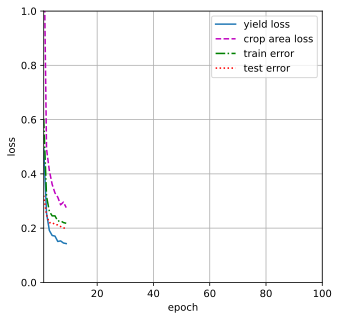

In [ ]:
if (test_env == 'notebook'):
  best_params['num_epochs'] = 100
  y_num_id_df = combined_dfs['LABEL_NUMERIC_IDS']
  x_num_id_df = combined_dfs['INPUT_NUMERIC_IDS']
  net, preds_l, preds_h, valid_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                      best_params,
                                                                      is_validation=True,
                                                                      early_stopping=True,
                                                                      visualize=True)
  print('Validation NRMSE:', round(100 * valid_nrmse, 2))
  low_res_pred_cols =["id0", "id_y", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = pd.DataFrame(data=preds_l, columns=low_res_pred_cols)

  low_res_pred_df = low_res_pred_df.merge(y_num_id_df, on=['id0', 'id_y']).drop(columns=['id0', 'id_y'])
  low_res_pred_cols =["COUNTRY", low_res_id_col, "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = low_res_pred_df[low_res_pred_cols]

  high_res_pred_df = pd.DataFrame(data=preds_h, columns=["id_x", "FYEAR", "YIELD_PRED"])
  high_res_pred_df = high_res_pred_df.merge(x_num_id_df, on=['id_x'])
  if (label_spatial_level == 'NUTS2'):
    yield_sel_cols = ['id_x', 'FYEAR', 'YIELD']
    high_res_pred_df = high_res_pred_df.merge(nuts3_yield_df[yield_sel_cols], on=['id_x', "FYEAR"])
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD", "YIELD_PRED"]
  else:
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD_PRED"]

  high_res_pred_df = high_res_pred_df[high_res_pred_cols]
  countries = low_res_pred_df['COUNTRY'].unique()
  valid_info = '\nValidation Set NRMSEs'
  valid_info += '\n---------------------'
  for cn in countries:
    print('\n', crop, cn)
    valid_info += '\n' + crop + '(' + cn + ')'
    cn_low_res_df = low_res_pred_df[low_res_pred_df['COUNTRY'] == cn]
    cn_high_res_df = high_res_pred_df[high_res_pred_df['COUNTRY'] == cn]
    lres_nrmse = NormalizedRMSE(cn_low_res_df['YIELD'].values,
                                cn_low_res_df['YIELD_PRED'].values)
    print('Level y NRMSE:', lres_nrmse)
    valid_info += '\nLevel y NRMSE:' + str(lres_nrmse)
    print(cn_low_res_df.head(10))
    if (label_spatial_level == 'NUTS2'):
      hres_nrmse = NormalizedRMSE(cn_high_res_df['YIELD'].values,
                                  cn_high_res_df['YIELD_PRED'].values)
      print('\nLevel x NRMSE:', hres_nrmse)
      valid_info += '\nLevel x NRMSE:' + str(hres_nrmse)
      print(cn_high_res_df.head(10))

  log_fh.write(valid_info)
  saved_net_name = cyp_config['architecture'] + '-valid.net'
  torch.save(net.state_dict(), '/content/' + saved_net_name)

### Evaluate on test data

NRMSE: 0.2109
Test NRMSE: 21.09

 soft wheat DE
Level y NRMSE: 21.890401751469494
  COUNTRY NUTS2_ID   FYEAR  YIELD  YIELD_PRED  CROP_AREA  CROP_AREA_PRED
0      DE     DE11  2013.0   7.56    7.399640    95312.0    70907.671875
1      DE     DE11  2014.0   8.29    7.137938    93025.0    55572.492188
2      DE     DE11  2015.0   7.73    7.227042    95852.0    65322.687500
3      DE     DE11  2016.0   6.74    7.468122    92208.0    69019.937500
4      DE     DE11  2017.0   7.60    7.490967    87077.0    73465.164062
5      DE     DE12  2013.0   6.72    7.429036    41521.0    48646.867188
6      DE     DE12  2014.0   7.32    7.105481    40525.0    35795.015625
7      DE     DE12  2015.0   6.90    7.238248    41759.0    44435.156250
8      DE     DE12  2016.0   6.17    7.522186    40170.0    47171.140625
9      DE     DE12  2017.0   6.91    7.537544    37933.0    51294.164062

Level x NRMSE: 13.907394285326927
  COUNTRY NUTS2_ID NUTS3_ID   FYEAR  YIELD  YIELD_PRED
0      DE     DE11    DE1

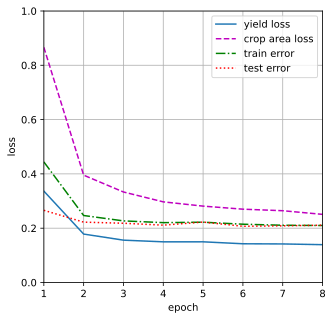

In [ ]:
if (test_env == 'notebook'):
  y_num_id_df = combined_dfs['LABEL_NUMERIC_IDS']
  x_num_id_df = combined_dfs['INPUT_NUMERIC_IDS']
  net, preds_l, preds_h, test_nrmse = evaluateOptimalHyperparameters(cyp_config,
                                                                     best_params,
                                                                     is_validation=False,
                                                                     early_stopping=False,
                                                                     visualize=True)
  print('Test NRMSE:', round(100 * test_nrmse, 2))
  low_res_pred_cols =["id0", "id_y", "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = pd.DataFrame(data=preds_l, columns=low_res_pred_cols)
  
  low_res_pred_df = low_res_pred_df.merge(y_num_id_df, on=['id0', 'id_y']).drop(columns=['id0', 'id_y'])
  low_res_pred_cols =["COUNTRY", low_res_id_col, "FYEAR", "YIELD", "YIELD_PRED", "CROP_AREA", "CROP_AREA_PRED"]
  low_res_pred_df = low_res_pred_df[low_res_pred_cols]

  high_res_pred_df = pd.DataFrame(data=preds_h, columns=["id_x", "FYEAR", "YIELD_PRED"])
  high_res_pred_df = high_res_pred_df.merge(x_num_id_df, on=['id_x'])
  if (label_spatial_level == 'NUTS2'):
    yield_sel_cols = ['id_x', 'FYEAR', 'YIELD']
    high_res_pred_df = high_res_pred_df.merge(nuts3_yield_df[yield_sel_cols], on=['id_x', "FYEAR"])
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD", "YIELD_PRED"]
  else:
    high_res_pred_cols =["COUNTRY", low_res_id_col, high_res_id_col, "FYEAR", "YIELD_PRED"]

  high_res_pred_df = high_res_pred_df[high_res_pred_cols]
  countries = low_res_pred_df['COUNTRY'].unique()
  test_info = '\nTest Set NRMSEs'
  test_info += '\n---------------'
  for cn in countries:
    print('\n', crop, cn)
    test_info += '\n' + crop + '(' + cn + ')'
    cn_low_res_df = low_res_pred_df[low_res_pred_df['COUNTRY'] == cn]
    cn_high_res_df = high_res_pred_df[high_res_pred_df['COUNTRY'] == cn]
    lres_nrmse = NormalizedRMSE(cn_low_res_df['YIELD'].values,
                                cn_low_res_df['YIELD_PRED'].values)
    print('Level y NRMSE:', lres_nrmse)
    test_info += '\nLevel y NRMSE:' + str(lres_nrmse)
    print(cn_low_res_df.head(10))
    if (label_spatial_level == 'NUTS2'):
      hres_nrmse = NormalizedRMSE(cn_high_res_df['YIELD'].values,
                                  cn_high_res_df['YIELD_PRED'].values)
      print('\nLevel x NRMSE:', hres_nrmse)
      test_info += '\nLevel x NRMSE:' + str(hres_nrmse)
      print(cn_high_res_df.head(10))

  output_path = cyp_config['output_path']
  high_res_pred_file = getPredictionFilename(cyp_config['crop'],
                                             cyp_config['use_yield_trend'],
                                             cyp_config['early_season_end_dekad'],
                                             cyp_config['country_code'],
                                             cyp_config['input_spatial_level'])
  high_res_pred_df.to_csv(output_path + '/' + high_res_pred_file + '.csv', index=False)

  low_res_pred_file = getPredictionFilename(cyp_config['crop'],
                                            cyp_config['use_yield_trend'],
                                            cyp_config['early_season_end_dekad'],
                                            cyp_config['country_code'],
                                            cyp_config['label_spatial_level'])

  low_res_pred_df.to_csv(output_path + '/' + low_res_pred_file + '.csv', index=False)

  log_fh.write(test_info)
  saved_net_name = cyp_config['architecture'] + '-full.net'
  torch.save(net.state_dict(), '/content/' + saved_net_name)

In [ ]:
log_fh.close()